# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём 

можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, 

комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

`Заказчику важны:`

* качество предсказания;
* скорость предсказания;
* время обучения.

**Признаки**

`DateCrawled` — *дата скачивания анкеты из базы*

`VehicleType` — *тип автомобильного кузова*

`RegistrationYear` — *год регистрации автомобиля*

`Gearbox` — *тип коробки передач*

`Power` — *мощность (л. с.)*

`Model` — *модель автомобиля*

`Kilometer` — *пробег (км)*

`RegistrationMonth` — *месяц регистрации автомобиля*

`FuelType` — *тип топлива*

`Brand` — *марка автомобиля*

`NotRepaired` — *была машина в ремонте или нет*

`DateCreated` — *дата создания анкеты*

`NumberOfPictures` — *количество фотографий автомобиля*

`PostalCode` — *почтовый индекс владельца анкеты (пользователя)*

`LastSeen` — *дата последней активности пользователя*

**Целевой признак**

`Price` — *цена (евро)*

## Подготовка данных

In [1]:
!pip install tabulate 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


from tabulate import tabulate

In [3]:
# Константы которые я вынес сразу в начало проекта
RANDOM_STATE = 12345
TEST_SIZE = 0.2
N_SPLITS = 3
CV = ShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [4]:
df = pd.read_csv('C:Downloads/autos.csv')

In [5]:
def func(q):
    display('------------------------------------------------------------------------')
    display(q.info())
    display('------------------------------------------------------------------------')
    display(q.shape)
    display('------------------------------------------------------------------------')
    display(q.head(5))
    display('------------------------------------------------------------------------')
    print('Дубликаты:',q.duplicated().sum())
    display('------------------------------------------------------------------------')
    print('Пропущеные значения:',q.isnull().sum())
    display('------------------------------------------------------------------------')
    print(q.describe())
    return q
func(df)

'------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

'------------------------------------------------------------------------'

(354369, 16)

'------------------------------------------------------------------------'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


'------------------------------------------------------------------------'

Дубликаты: 4


'------------------------------------------------------------------------'

Пропущеные значения: DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


'------------------------------------------------------------------------'

               Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


### Вывод


* Необходимо перевести тип данных столбцов: DateCrawled/RegistrationMonth/DateCreated

* Так же были замечены дубликаты в количестве 4 шт

* Необходимо перевести колонки к змеиному регистру для того, чтобы нам было комфортно с ними работать

* Избавиться от пропущенных значений

* Значение столбца NumberOfPictures одни нули,предполагаю он нам не понадобиться

* В столбцах Price/Power есть нулевые значения. Скорее всего это аномалии будем дальше решать,что с ними делать.

------------------------
**Переходим дальше к предобработке того что мы заметили.**

## Предобработка данных

In [6]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [7]:
df.columns = df.columns.str.lower()

In [8]:
# Переведём к змеиному регистру наши данные
df = df.rename(columns={
    'datecrawled': 'date_crawled','vehicletype': 'vehicle_type','registrationyear': 'registration_year',
    'kilometer': 'km','registrationmonth': 'registration_month','fueltype': 'fuel_type', 'notrepaired': 'not_repaired',
    'datecreated': 'date_created','postalcode': 'postal_code','numberofpictures': 'number_of_pictures',
    'lastseen': 'last_seen',
})
# df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   km                  354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [10]:
# удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [11]:
# Изменим тип данных
df['date_crawled'],df['last_seen'] = pd.to_datetime(df['date_crawled']),pd.to_datetime(df['last_seen'])
df = df.set_index('date_crawled')

*В данном пункте год регистрации мы нашли выбивающиесяя значения. Мы понимаем, что года до примерно 1940 машины просто не были выставлены. Предположу, что с 1940 можно оставить значения так как машины могут быть раритетные.*

*Так же наши данные были 2016 года и то что выше этой даты это ошибочные значения пользователей.*

**Будем от них избавляться**

In [12]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [13]:
df = df.loc[(df['registration_year'] >= 1940) & (df['registration_year'] <= 2016)]

# Так же удалим столбцы которые не несут смысловой нагрузки

df = df.drop(['number_of_pictures','date_created','postal_code','last_seen'], axis=1)

*На графике видно, что машин с годом регистрации мало,в основном люди продают с 1980 года регистрации.*

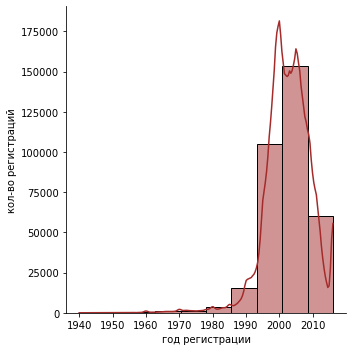

In [14]:
sns.displot(df['registration_year'],bins=10, color='brown',kde=True)

plt.ylabel('кол-во регистраций')
plt.xlabel('год регистрации')

plt.show()

In [15]:
df.describe()

,price,registration_year,power,km,registration_month
count,339613.000000,339613.000000,339613.000000,339613.000000,339613.000000
mean,4471.992338,2002.521073,111.042849,128120.669703,5.758351
std,4545.621085,6.853154,186.901753,37846.324377,3.707613
min,0.000000,1940.000000,0.000000,5000.000000,0.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 339613 entries, 2016-03-24 11:52:17 to 2016-03-20 19:41:08
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               339613 non-null  int64 
 1   vehicle_type        316772 non-null  object
 2   registration_year   339613 non-null  int64 
 3   gearbox             321795 non-null  object
 4   power               339613 non-null  int64 
 5   model               322069 non-null  object
 6   km                  339613 non-null  int64 
 7   registration_month  339613 non-null  int64 
 8   fuel_type           312450 non-null  object
 9   brand               339613 non-null  object
 10  not_repaired        274926 non-null  object
dtypes: int64(5), object(6)
memory usage: 31.1+ MB


In [17]:
print('количество аномалий в цене(процентах):',df['price'].loc[df['price'] < 50].shape[0] / df.shape[0] * 100,'%')
print('количество аномалий в мощности(процентах): ',df['power'].loc[df['power'] == 0].shape[0] / df.shape[0] * 100,'%')
print('количество аномалий в месяц регистрации(процентах): ',df['registration_month'].loc[df['registration_month'] == 0].shape[0] / df.shape[0] * 100,'%')

количество аномалий в цене(процентах): 3.388268411397679 %
количество аномалий в мощности(процентах):  10.698942619982157 %
количество аномалий в месяц регистрации(процентах):  9.872119147382461 %


*Количество аномальных около `3.3%` в цене, это мало поэтому будем избавляться от них. Это ошибочные цены,машина стоящая 50 евро не правдоподобно.*

*Так же мы видим присутствие аномалий у мощности автомобиля `10.6 %` и месяц регистрации `9.8%`. Нулевые значения,этого не может быть,поэтому будем заменять медианным значением по столбцу.*

In [18]:
df = df.loc[(df['price'] > 50) & (df['power'] <= 500)]

In [19]:
df['power'] = df['power'].replace(0,df['power'].median())
df['registration_month'] = df['registration_month'].replace(0,df['registration_month'].median())

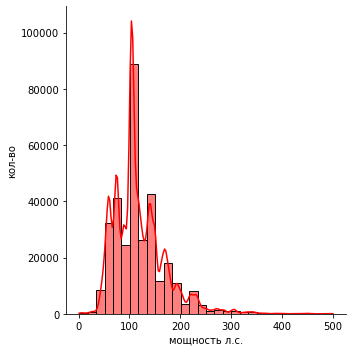

In [20]:
sns.displot(df['power'],bins=30, color='red',kde=True)

plt.ylabel('кол-во')
plt.xlabel('мощность л.с.')

plt.show()

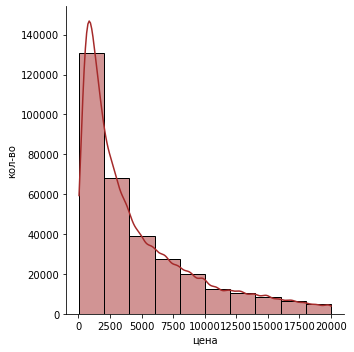

In [21]:
sns.displot(df['price'],bins=10, color='brown',kde=True)

plt.ylabel('кол-во')
plt.xlabel('цена')

plt.show()

In [22]:
display(df.isnull().sum())
display(df.isnull().sum() / len(df))

price                     0
vehicle_type          19062
registration_year         0
gearbox               14769
power                     0
model                 15173
km                        0
registration_month        0
fuel_type             23232
brand                     0
not_repaired          58572
dtype: int64

price                 0.000000
vehicle_type          0.058222
registration_year     0.000000
gearbox               0.045110
power                 0.000000
model                 0.046344
km                    0.000000
registration_month    0.000000
fuel_type             0.070959
brand                 0.000000
not_repaired          0.178900
dtype: float64

*Пропущеных значений больше 5%*

* Значение была машина в ремонте или нет. Заменим на `no`. Предположение,что люди пропускают заполнение этого столбца так как она не находится на ремонте.

* У типа топлива, коробки передач,тип кузова, модели - пропуски заменим на `Другой`. Аргументирую это тем,что заменив каким-либо значением ,мы можем ошибаться. Имеется ввиду заменить медианой или модой к примеру. Мы не знаем какая была коробка на машине или какой кузов стоял у данного клиента. Изменив на какое-то значение мы исказим данные,а значит не правильно обучим нашу модель.


In [23]:
df['not_repaired'] = df['not_repaired'].fillna('no')
df['fuel_type']  = df['fuel_type'].fillna('other')
df['gearbox'] = df['gearbox'].fillna('other')
df['vehicle_type'] = df['vehicle_type'].fillna('other')
df['model'] = df['model'].fillna('unknown')

*Взглянем на корреляцию наших значений. Зависимости ярко выраженной у наших признаков нет.*

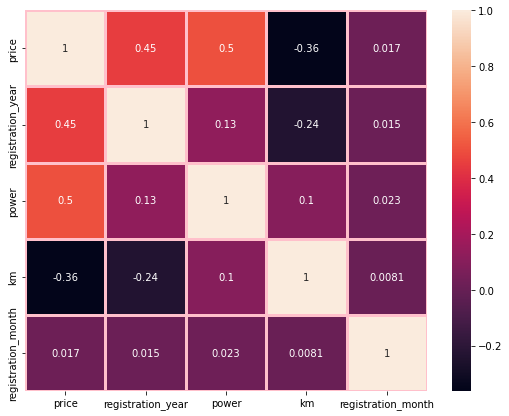

In [24]:
plt.rcParams['figure.figsize'] = (9.0, 7.0)
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='pink')
plt.show()

*После удаления неинформативных признаков давайте проверим данные на дубликаты снова.*

In [25]:
df.duplicated().sum()

28982

In [26]:
# удалим дубликаты снова
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [27]:
df.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,km,registration_month,fuel_type,brand,not_repaired
0,480,other,1993,manual,105,golf,150000,6,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Вывод

* Заменили пропуски 

* Привели данные к змеиному регистру

* Проверили корреляцию наших значений

* Удалили дубликаты и обработали аномальные значения

**Переходим к подготовке к обучению**

## Подготовка к обучению

In [28]:
columns_ohe = ['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']
df_ohe = pd.get_dummies(df, drop_first=True,columns=columns_ohe)
df_ohe

,price,registration_year,power,km,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
0,480,1993,105,150000,6,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298413,3200,2004,225,150000,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
298414,2200,2005,105,20000,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
298415,1199,2000,101,125000,3,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
298416,9200,1996,102,150000,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
df_train, df_test = train_test_split(df_ohe, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [30]:
features_train, target_train = df_train.drop(['price'],axis=1), df_train['price']
features_test, target_test = df_test.drop(['price'],axis=1), df_test['price']

In [31]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(238734, 309)

(238734,)

(59684, 309)

(59684,)

In [32]:
numeric = ['km','registration_year','power','registration_month']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

*Добавим для наших обычных моделей порядковое кодирование*

In [33]:
df.dtypes

price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
km                     int64
registration_month     int64
fuel_type             object
brand                 object
not_repaired          object
dtype: object

In [34]:
categorial_variables = ['vehicle_type','gearbox','model','fuel_type', 'brand', 'not_repaired']

encoder = OrdinalEncoder()

df_ord = df.copy()
df_ord[categorial_variables] = encoder.fit_transform(df_ord[categorial_variables])
display(df_ord.head(10))

,price,vehicle_type,registration_year,gearbox,power,model,km,registration_month,fuel_type,brand,not_repaired
0,480,3.0,1993,1.0,105,116.0,150000,6,6.0,38.0,0.0
1,18300,2.0,2011,1.0,190,228.0,125000,5,2.0,1.0,1.0
2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0
6,2200,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0
7,14500,0.0,2014,1.0,125,60.0,30000,8,6.0,10.0,0.0
8,999,5.0,1998,1.0,101,116.0,150000,6,5.0,38.0,0.0
9,2000,4.0,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0


In [35]:
target = df_ord['price']
features = df_ord.drop(['price'], axis=1)
    
features_train_ord, features_test_ord, target_train_ord, target_test_ord = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [36]:

scaler_1 = StandardScaler()
scaler_1.fit(features_train_ord)

features_train_ord = scaler_1.transform(features_train_ord)
features_test_ord = scaler_1.transform(features_test_ord)

In [37]:
display(features_train_ord.shape)
display(features_test_ord.shape)
display(target_train_ord.shape)
display(target_test_ord.shape)

(238734, 10)

(59684, 10)

(238734,)

(59684,)

## Обучение моделей

In [38]:
# функция которая находит RMSE
def rmse_score(target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
# константа
SCORER = make_scorer(rmse_score, greater_is_better=False)

In [39]:
# функция которая считает время работы модели/предсказания/RMSE
def model_score(model, features_train, target_train, features_test, target_test):
    
    start_time = time.time()    
    model.fit(features_train, target_train)
    finish_time = time.time() - start_time
    
    start_predict = time.time()  
    model_predict = model.predict(features_test)
    predict_time = time.time() - start_predict

    return finish_time, predict_time, rmse_score(target_test,model_predict).round(2)

### Линейная регрессия

In [40]:
lr_model = LinearRegression()
display(f'Время модели/предсказания/RMSE для линейной регрессии: {model_score(lr_model,features_train,target_train,features_test,target_test)}')

'Время модели/предсказания/RMSE для линейной регрессии: (4.968554735183716, 0.09412455558776855, 2676.12)'

### Cлучайный лес

In [41]:
# ищем лучшие параметры
forest_model = RandomForestRegressor(random_state=RANDOM_STATE)
    
forest_params = {'n_estimators': range(9, 79, 9),
                 'max_depth': [2, 4, 6, 9]}

forest_grid = GridSearchCV(forest_model, forest_params,
                         cv=CV, verbose=3, scoring=SCORER)

forest_grid.fit(features_train_ord, target_train_ord)

display(forest_grid.best_score_)
display(forest_grid.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END ...max_depth=2, n_estimators=9;, score=-3194.152 total time=   0.7s
[CV 2/3] END ...max_depth=2, n_estimators=9;, score=-3162.736 total time=   0.6s
[CV 3/3] END ...max_depth=2, n_estimators=9;, score=-3194.366 total time=   0.6s
[CV 1/3] END ..max_depth=2, n_estimators=18;, score=-3194.102 total time=   1.4s
[CV 2/3] END ..max_depth=2, n_estimators=18;, score=-3163.072 total time=   1.4s
[CV 3/3] END ..max_depth=2, n_estimators=18;, score=-3194.223 total time=   1.4s
[CV 1/3] END ..max_depth=2, n_estimators=27;, score=-3194.135 total time=   2.5s
[CV 2/3] END ..max_depth=2, n_estimators=27;, score=-3162.778 total time=   2.3s
[CV 3/3] END ..max_depth=2, n_estimators=27;, score=-3194.468 total time=   2.1s
[CV 1/3] END ..max_depth=2, n_estimators=36;, score=-3194.209 total time=   2.8s
[CV 2/3] END ..max_depth=2, n_estimators=36;, score=-3162.708 total time=   2.8s
[CV 3/3] END ..max_depth=2, n_estimators=36;, sc

-1987.2725282036645

{'max_depth': 9, 'n_estimators': 72}

In [42]:
forest_model = RandomForestRegressor(random_state=RANDOM_STATE,n_estimators=70,max_depth=9)
display(f'Время модели/предсказания/RMSE для RandoForest регрессии: {model_score(forest_model,features_train_ord,target_train_ord,features_test_ord,target_test_ord)}')

'Время модели/предсказания/RMSE для RandoForest регрессии: (18.492275714874268, 0.2511265277862549, 1996.89)'

### Cтохастического градиентного спуска SGD

In [43]:
# ищем лучшие параметры
sgd_model = SGDRegressor(random_state=RANDOM_STATE)
parameters_grid = {'alpha' : [0.0001, 0.001],
                   'max_iter': [50, 1000],}
sgd_grid = GridSearchCV(sgd_model, parameters_grid, scoring=SCORER, cv=CV)
sgd_grid.fit(features_train,target_train)
display(sgd_grid.best_score_)
display(sgd_grid.best_params_)

C:\Users\baffe\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\baffe\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\baffe\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\baffe\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before 

-2676.1702077626305

{'alpha': 0.0001, 'max_iter': 1000}

In [44]:
sgd_model = SGDRegressor(random_state=RANDOM_STATE, alpha=0.0001,max_iter=1000)
display(f'Время модели/предсказания/RMSE для SGD регрессии: {model_score(sgd_model,features_train,target_train,features_test,target_test)}')

'Время модели/предсказания/RMSE для SGD регрессии: (20.59925866127014, 0.07848739624023438, 2683.29)'

### Градиентный бустинг XGBoost

In [45]:
# ищем лучшие параметры
XGB_model = xgb.XGBRegressor(random_state=RANDOM_STATE)
display(XGB_model)
parameters_grid = {'max_depth': [2, 4, 6],
                 'n_estimators': [50, 100, 300],}
grid_XGB = GridSearchCV(XGB_model, parameters_grid, scoring=SCORER, cv=CV)
grid_XGB.fit(features_train, target_train, verbose=True)
display(grid_XGB.best_score_)
display(grid_XGB.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=12345,
             reg_alpha=None, reg_lambda=None, ...)

-1614.3682566973223

{'max_depth': 6, 'n_estimators': 300}

In [47]:
XGB_model = xgb.XGBRegressor(random_state=RANDOM_STATE,max_depth=6,n_estimators=300)
display(f'Время модели/предсказания/RMSE для Xgb регрессии: {model_score(XGB_model,features_train,target_train,features_test,target_test)}')

'Время модели/предсказания/RMSE для Xgb регрессии: (134.0583348274231, 0.29799890518188477, 1625.05)'

### Градиентный бустинг CatBoost

In [48]:
# ищем лучшие параметры
CatBoost_model = CatBoostRegressor(random_state=RANDOM_STATE)
parameters_grid = {'max_depth': [2, 4, 12],
                   'learning_rate': [0.05,0.03, 0.1],
                   'l2_leaf_reg': [1, 3, 5, 7, 9],
                   'iterations': [50, 100, 120]}
grid_CAT = GridSearchCV(CatBoost_model, parameters_grid, scoring=SCORER, cv=CV)
grid_CAT.fit(features_train, target_train)
display(grid_CAT.best_score_)
display(grid_CAT.best_params_)

0:	learn: 4445.4728504	total: 179ms	remaining: 8.78s
1:	learn: 4341.6831484	total: 188ms	remaining: 4.51s
2:	learn: 4245.2427465	total: 196ms	remaining: 3.07s
3:	learn: 4155.4753405	total: 204ms	remaining: 2.34s
4:	learn: 4072.7844293	total: 212ms	remaining: 1.91s
5:	learn: 3995.0685648	total: 221ms	remaining: 1.62s
6:	learn: 3919.5394486	total: 230ms	remaining: 1.41s
7:	learn: 3851.6641101	total: 240ms	remaining: 1.26s
8:	learn: 3786.0586600	total: 249ms	remaining: 1.14s
9:	learn: 3725.8579367	total: 257ms	remaining: 1.03s
10:	learn: 3670.7732154	total: 266ms	remaining: 945ms
11:	learn: 3619.0660397	total: 275ms	remaining: 870ms
12:	learn: 3567.8497290	total: 282ms	remaining: 803ms
13:	learn: 3521.3106608	total: 290ms	remaining: 746ms
14:	learn: 3476.5440253	total: 298ms	remaining: 694ms
15:	learn: 3433.3734982	total: 305ms	remaining: 648ms
16:	learn: 3394.5987556	total: 313ms	remaining: 607ms
17:	learn: 3358.1400980	total: 321ms	remaining: 571ms
18:	learn: 3320.1325151	total: 329ms	r

-1675.728308115684

{'iterations': 120, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 12}

In [49]:
CatBoost_model = CatBoostRegressor(random_state=RANDOM_STATE,max_depth=12,l2_leaf_reg=1,learning_rate=0.1,iterations=120)
display(f'Время модели/предсказания/RMSE для CatBoost регрессии: {model_score(CatBoost_model,features_train,target_train,features_test,target_test)}')

0:	learn: 4225.0067132	total: 70.9ms	remaining: 8.44s
1:	learn: 3935.4084747	total: 144ms	remaining: 8.5s
2:	learn: 3674.2786614	total: 213ms	remaining: 8.3s
3:	learn: 3447.0255609	total: 289ms	remaining: 8.37s
4:	learn: 3246.7061618	total: 360ms	remaining: 8.28s
5:	learn: 3068.0085550	total: 432ms	remaining: 8.21s
6:	learn: 2913.4045552	total: 507ms	remaining: 8.19s
7:	learn: 2779.0100883	total: 586ms	remaining: 8.2s
8:	learn: 2660.9844627	total: 655ms	remaining: 8.08s
9:	learn: 2552.0768336	total: 731ms	remaining: 8.04s
10:	learn: 2458.8009857	total: 816ms	remaining: 8.08s
11:	learn: 2372.6133559	total: 895ms	remaining: 8.05s
12:	learn: 2301.8418198	total: 975ms	remaining: 8.02s
13:	learn: 2242.1820335	total: 1.05s	remaining: 7.97s
14:	learn: 2184.8933138	total: 1.13s	remaining: 7.93s
15:	learn: 2138.4167370	total: 1.22s	remaining: 7.91s
16:	learn: 2099.3564349	total: 1.3s	remaining: 7.86s
17:	learn: 2062.9742857	total: 1.38s	remaining: 7.8s
18:	learn: 2032.4380922	total: 1.46s	remai

'Время модели/предсказания/RMSE для CatBoost регрессии: (9.311714172363281, 0.04725980758666992, 1692.26)'

###  Градиентный бустинг LightGBM

In [50]:
# ищем лучшие параметры
LightGBM_model = LGBMRegressor(random_state=RANDOM_STATE)
parameters_grid = {'max_depth': [2, 4, 10],
                   'learning_rate': [0.03, 0.1],
                   'n_estimators': [50, 100, 200, 500]}
grid_LightGBM = GridSearchCV(LightGBM_model, parameters_grid, scoring=SCORER, cv=CV)
grid_LightGBM.fit(features_train, target_train)
display(grid_LightGBM.best_score_)
display(grid_LightGBM.best_params_)

-1615.7100877257817

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

In [51]:
LightGBM_model = LGBMRegressor(random_state=RANDOM_STATE,max_depth=10,learning_rate=0.1,n_estimators=500)
display(f'Время модели/предсказания/RMSE для LightGBM регрессии: {model_score(LightGBM_model,features_train,target_train,features_test,target_test)}')

'Время модели/предсказания/RMSE для LightGBM регрессии: (2.8374526500701904, 0.5313043594360352, 1627.46)'

## Анализ моделей

In [52]:
model_info = {'model': ['LR','RF','SGD','XGBoost','CatBoost','LightGBM'],
              'RMSE': [2676.12, 1996.89, 2641.55, 1625.05, 1692.26, 1627.46],
              'work_time': [4.96, 18.49, 20.59, 134.05, 9.31, 2.83], 
              'speed_time': [0.09, 0.25, 0.07, 0.29, 0.04 , 0.53],
              'quality': ['worse_RMSE','middle_model','worse_RMSE','worse_work/best_RMSE','middle_model','best_model']
             } 

In [53]:
print(tabulate(model_info, headers='keys', tablefmt="grid",stralign='center'))

+----------+---------+-------------+--------------+----------------------+
|  model   |    RMSE |   work_time |   speed_time |       quality        |
+==========+=========+=============+==============+======================+
|    LR    | 2676.12 |        4.96 |         0.09 |      worse_RMSE      |
+----------+---------+-------------+--------------+----------------------+
|    RF    | 1996.89 |       18.49 |         0.25 |     middle_model     |
+----------+---------+-------------+--------------+----------------------+
|   SGD    | 2641.55 |       20.59 |         0.07 |      worse_RMSE      |
+----------+---------+-------------+--------------+----------------------+
| XGBoost  | 1625.05 |      134.05 |         0.29 | worse_work/best_RMSE |
+----------+---------+-------------+--------------+----------------------+
| CatBoost | 1692.26 |        9.31 |         0.04 |     middle_model     |
+----------+---------+-------------+--------------+----------------------+
| LightGBM | 1627.46 |   

* После проверки наших моделей лучшие показатели скорости и время работы - **LightGBM**

* Лучшие показатели RMSE - **XGBoost**

* Лучшая модель по моему мнению стала - **LightGBM** 
 * у данной модели отличные показатели RMSE и одна из самых высоких скоростей обучения и времени предсказания

## Выводы

---------------
1. Проделали подготовку данных. Где мы обнаружили:

* Необходимо перевести тип данных столбцов: DateCrawled/RegistrationMonth/DateCreated

* Так же были замечены дубликаты в количестве 4 шт

* Необходимо перевести колонки к змеиному регистру для того, чтобы нам было комфортно с ними работать

* Избавиться от пропущенных значений

* Значение столбца NumberOfPictures одни нули,предполагаю он нам не понадобиться

* В столбцах Price/Power/registration_month есть нулевые значения. Скорее всего это аномалии будем дальше решать,что с ними делать.
------------------------------------
2. Проделали предобработку данных.

* Сделали предположения причины аномалий,обработали их.

* Заменили пропуски 

* Привели данные к змеиному регистру

* Проверили корреляцию наших значений
-----------------------------------------------
3. Обучели наши модели и нашли лучшие параметры для них.
------------
4. Нашли лучшую модель для нашего задания **LightGBM** 
  * со значениям: RMSE: `1627.46` , Время обучения: `2.83`, Скорость обучения: `0.53`   